# 引入包

## 常规包

In [1]:
import os
import numpy as np
import random
import pickle
from itertools import permutations

from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.svm import SVC

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import seaborn as sns

## keras包

In [2]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.datasets import mnist

from keras import backend as K

Using TensorFlow backend.


# 加载mnist数据

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(type(x_train))
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

<class 'numpy.ndarray'>
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [4]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)

print(x_train.shape)

(60000, 28, 28)


# 自定义画图函数

In [8]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    """
       x: 一个list，0是特征，1是标签 
    """
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))  # 调色板

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[labels.astype(np.int)])
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label. 标签位置是该类点的平均位置
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    # plt.savefig(subtitle)

# TSNE - 可视化 - **初始**聚类效果

<class 'numpy.ndarray'> (512, 2)


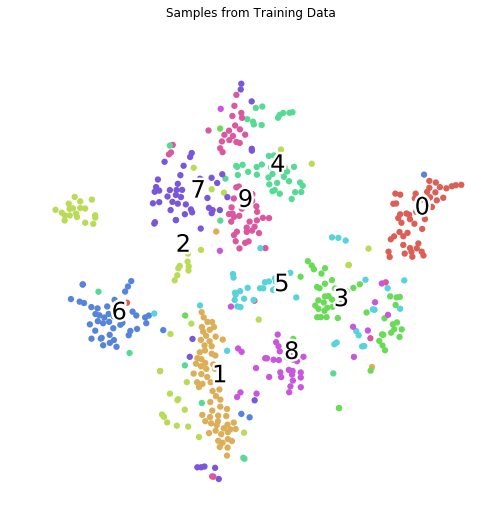

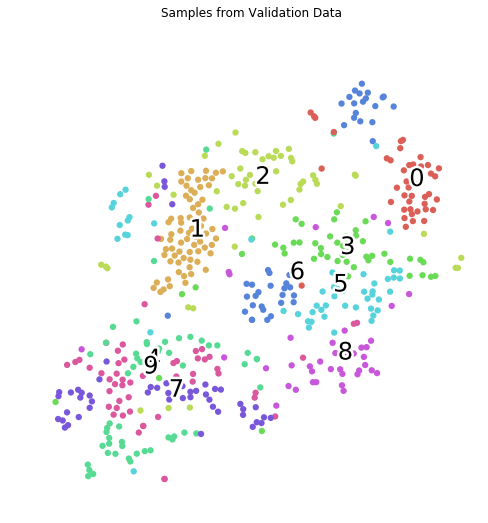

In [7]:
tsne = TSNE()

train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")
print(type(train_tsne_embeds), train_tsne_embeds.shape)

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

# mnist - tripet训练前 - 分类模型 - 搭建

In [64]:
Classifier_input = Input((784,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

Classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [65]:
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)

print(y_train_onehot.shape, y_test_onehot.shape)
print(y_train_onehot[0:2])

(60000, 10) (10000, 10)
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


In [66]:
Classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
Classifier_model.fit(x_train_flat, y_train_onehot, validation_data=(x_test_flat,y_test_onehot), epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 152us/step - loss: 6.0452 - acc: 0.6188 - val_loss: 4.8367 - val_acc: 0.6943
Epoch 2/20
60000/60000 [==============================] - 3s 55us/step - loss: 4.5445 - acc: 0.7148 - val_loss: 4.6504 - val_acc: 0.7091
Epoch 3/20
60000/60000 [==============================] - 3s 55us/step - loss: 4.4730 - acc: 0.7201 - val_loss: 4.5308 - val_acc: 0.7161
Epoch 4/20
60000/60000 [==============================] - 3s 53us/step - loss: 4.3671 - acc: 0.7268 - val_loss: 4.3132 - val_acc: 0.7295
Epoch 5/20
60000/60000 [==============================] - 6s 95us/step - loss: 4.3827 - acc: 0.7262 - val_loss: 4.2637 - val_acc: 0.7338
Epoch 6/20
60000/60000 [==============================] - 5s 83us/step - loss: 4.4372 - acc: 0.7228 - val_loss: 4.2039 - val_acc: 0.7377
Epoch 7/20
60000/60000 [==============================] - 5s 87us/step - loss: 4.3347 - acc: 0.7297 - val_loss: 4.4504 - val_ac

# 三元组 - 数据生成器

In [14]:
def generate_triplet(x, y, testsize=0.3, ap_pairs=10, an_pairs=10):
    """
    ap_pairs：anchor和positive 样本对 数量
    an_pairs: anchor和negative 样本对 数量
    """
    data_xy = tuple([x,y])
    trainsize = 1 - testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    
    for data_class in sorted(set(data_xy[1])):  # 遍历类别
        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        A_P_pairs = random.sample(list(permutations(same_class_idx, 2)), k=ap_pairs)  # Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx), k=an_pairs)

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor, Positive, Negative])
                
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor, Positive, Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [16]:
print(x_train_flat.shape, y_train.shape)

(60000, 784) (60000,)


## 生成三元组

In [17]:
X_train, X_test = generate_triplet(x_train_flat, y_train, ap_pairs=150, an_pairs=150, testsize=0.2)

print(X_train.shape, X_test.shape)

(180000, 3, 784) (45000, 3, 784)


# Triplet NN

## triplet loss

In [68]:
def triplet_loss(y_true, y_pred, alpha=0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
              1. anchor -- the encodings for the anchor data
              2. positive -- the encodings for the positive data (similar to anchor)
              3. negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ', y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
    
    anchor   = y_pred[:, 0:int(total_lenght*1/3)]
    positive = y_pred[:, int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:, int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor - positive), axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # compute loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)
 
    return loss

## 网络结构

In [31]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    
    # conv1 + pooling1
    model.add(
        Conv2D(
            128,
            (7,7),
            padding='same',
            input_shape=(in_dims[0], in_dims[1], in_dims[2],),
            activation='relu',
            name='conv1')
    )
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    
    # conv2 + pooling2
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    
    # dense embbeding
    model.add(Flatten(name='flatten'))
    model.add(Dense(4, name='embeddings'))
    # model.add(Dense(600))
    
    return model

## 优化器

In [33]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

## 共享参数 - 网络搭建

In [34]:
Shared_DNN = create_base_network([28,28,1,])
Shared_DNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 128)       6400      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 256)       819456    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
embeddings (Dense)           (None, 4)                 50180     
Total params: 876,036
Trainable params: 876,036
Non-trainable params: 0
_________________________________________________________________


In [35]:
anchor_input   = Input((28,28,1, ), name='anchor_input')
positive_input = Input((28,28,1, ), name='positive_input')
negative_input = Input((28,28,1, ), name='negative_input')

# Shared embedding layer for positive and negative items
encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 4)            876036      anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## 训练集合 - 整理

In [42]:
Anchor = X_train[:,0,:].reshape(-1,28,28,1)
Positive = X_train[:,1,:].reshape(-1,28,28,1)
Negative = X_train[:,2,:].reshape(-1,28,28,1)
print(Anchor.shape, Positive.shape)

Anchor_test = X_test[:,0,:].reshape(-1,28,28,1)
Positive_test = X_test[:,1,:].reshape(-1,28,28,1)
Negative_test = X_test[:,2,:].reshape(-1,28,28,1)
print(Anchor_test.shape, Positive_test.shape)

(180000, 28, 28, 1) (180000, 28, 28, 1)
(45000, 28, 28, 1) (45000, 28, 28, 1)


In [47]:
# y值构造无所谓，计算triplet loss时候，不需要y值
Y_dummy = np.empty((Anchor.shape[0], 1))
Y_dummy2 = np.empty((Anchor_test.shape[0], 1))

print(Y_dummy.shape, Y_dummy2.shape)

(180000, 1) (45000, 1)


## 训练 start

In [48]:
model.compile(loss=triplet_loss, optimizer=adam_optim)

y_pred.shape =  Tensor("merged_layer/concat:0", shape=(?, 12), dtype=float32)


In [49]:
model.fit(
    [Anchor, Positive, Negative], 
    y=Y_dummy, 
    validation_data=([Anchor_test, Positive_test, Negative_test], Y_dummy2), 
    batch_size=512, 
    epochs=2
)

Train on 180000 samples, validate on 45000 samples
Epoch 1/2
180000/180000 [==============================] - 2400s 13ms/step - loss: 0.2738 - val_loss: 6.4337
Epoch 2/2
180000/180000 [==============================] - 2389s 13ms/step - loss: 0.1043 - val_loss: 4.9468


## 训练后 - 编码网络

In [56]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
anchor_input (InputLayer)    (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 4)                 876036    
Total params: 876,036
Trainable params: 876,036
Non-trainable params: 0
_________________________________________________________________


## 模型 - 保存 - 加载

In [55]:
# trained_model.save_weights('./triplet_model_MNIST.hdf5')

In [25]:
trained_model.load_weights('./triplet_model_MNIST.hdf5')

# TSNE - 可视化 - **算法后**聚类效果

In [57]:
tsne = TSNE()

X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm  = trained_model.predict(x_test[:512].reshape(-1,28,28,1))

train_tsne_embeds = tsne.fit_transform(X_train_trm)
test_tsne_embeds = tsne.fit_transform(X_test_trm)

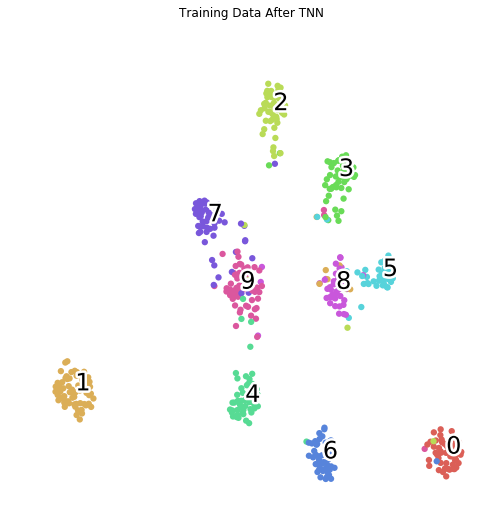

In [58]:
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")

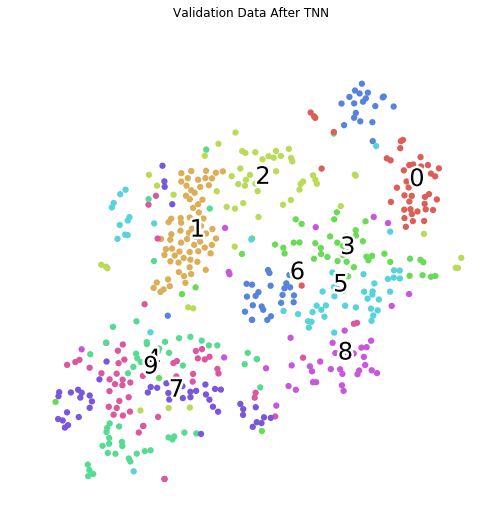

In [59]:
scatter(eval_tsne_embeds, y_test[:512], "Validation Data After TNN")

# mnist - tripet训练后- 分类模型 - 搭建

In [60]:
X_train_trm = trained_model.predict(x_train.reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test.reshape(-1,28,28,1))

print(x_train.shape, X_train_trm.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [61]:
Classifier_input = Input((4,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

Classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                50        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [63]:
Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm,y_train_onehot, validation_data=(X_test_trm,y_test_onehot), epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.3211 - acc: 0.9068 - val_loss: 0.3041 - val_acc: 0.9064
Epoch 2/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.3118 - acc: 0.9095 - val_loss: 0.2973 - val_acc: 0.9077
Epoch 3/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.3050 - acc: 0.9113 - val_loss: 0.2914 - val_acc: 0.9096
Epoch 4/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.2994 - acc: 0.9132 - val_loss: 0.2859 - val_acc: 0.9123
Epoch 5/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.2947 - acc: 0.9136 - val_loss: 0.2805 - val_acc: 0.9143
Epoch 6/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.2906 - acc: 0.9142 - val_loss: 0.2775 - val_acc: 0.9151
Epoch 7/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.2874 - acc: 0.9157 - val_loss: 0.2733 - val_acc